In [48]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [49]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [50]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [51]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [52]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [53]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [54]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [93]:
# Create our session (link) from Python to the DB
session = Session(engine)
inspector = inspect(engine)

def getcolumn(table):
    columns= inspector.get_columns(table)
    for c in columns:
        print(c["name"], c["type"])

In [56]:
stations = engine.execute("SELECT * FROM Station")
print(stations.keys())

['id', 'station', 'name', 'latitude', 'longitude', 'elevation']


In [57]:
stations.fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6),
 (6, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5),
 (7, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 (8, 'USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9),
 (9, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)]

In [59]:
columns = inspector.get_columns("Station")
for c in columns:
    print(c["name"], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [64]:
measurements = engine.execute("SELECT * FROM Measurement LIMIT 10")
print(measurements.keys())

['id', 'station', 'date', 'prcp', 'tobs']


In [65]:
measurements.fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0),
 (6, 'USC00519397', '2010-01-07', 0.06, 70.0),
 (7, 'USC00519397', '2010-01-08', 0.0, 64.0),
 (8, 'USC00519397', '2010-01-09', 0.0, 68.0),
 (9, 'USC00519397', '2010-01-10', 0.0, 73.0),
 (10, 'USC00519397', '2010-01-11', 0.01, 64.0)]

In [94]:
getcolumn("Measurement")

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


# Exploratory Precipitation Analysis

In [99]:
# Find the most recent date in the data set.
most_recent= session.query(Measurement.date).order_by(Measurement.date.desc()).first()
most_recent

('2017-08-23')

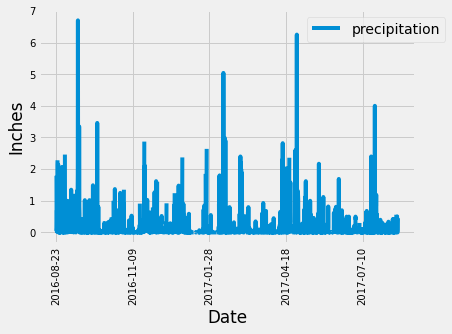

In [173]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.
one_year_ago = dt.date(2017, 8, 23)- dt.timedelta(days = 365)
one_year_ago

# Perform a query to retrieve the data and precipitation scores
one_year = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_ago).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(one_year, columns = ["Date", "precipitation"])
prcp_df.set_index("Date")
# Sort the dataframe by date
ordered_prcpdf = prcp_df.sort_values('Date').set_index("Date")
ordered_prcpdf

# Use Pandas Plotting with Matplotlib to plot the data
ordered_prcpdf.plot()
plt.ylabel("Inches")
plt.yticks(size = 10)
plt.xticks(size= 10, rotation=90)
plt.legend(loc= "upper right", bbox_to_anchor=(1.1, 1))
plt.savefig('precipitation.png', bbox_inches = 'tight')
plt.show()

In [174]:
# Use Pandas to calcualte the summary statistics for the precipitation data
ordered_prcpdf.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [184]:
# Design a query to calculate the total number stations in the dataset
station_total = session.query(Station.station).distinct().count()
print(f"There are {station_total} stations in the dataset.")

There are 9 stations in the dataset.


In [200]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
station_pop= session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

station_pop

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [206]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active = session.query(Measurement.station, func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == "USC00519281").all()

most_active_df = pd.DataFrame(most_active, columns = ('station', 'lowest temp', 'highest temp', 'avg temp')).set_index('station')
most_active_df

,lowest temp,highest temp,avg temp
station,,,
USC00519281,54.0,85.0,71.663781


In [212]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_recent_date = session.query(Measurement.date).\
    filter(Measurement.station =="USC00519281").\
    order_by(Measurement.date.desc()).first()

print(most_recent_date)

('2017-08-18',)


In [214]:
year_ago = dt.date(2017, 8, 18) - dt.timedelta(days = 365)
year_ago

datetime.date(2016, 8, 18)

In [221]:
tobs_data = session.query(Measurement.date, Measurement.tobs).\
    filter((Measurement.station == "USC00519281"), (Measurement.date >= year_ago)).\
    order_by(Measurement.date.desc()).all()

tobs_df = pd.DataFrame(tobs_data, columns=('Date', 'tobs')).set_index('Date')

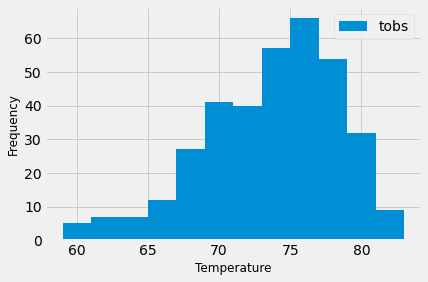

In [231]:
tobs_df.plot.hist(bins= 12)
plt.xlabel('Temperature', size = 12)
plt.ylabel('Frequency',size= 12)
plt.savefig('Most_Active_Station_Temps.png', bbox_inches = 'tight')
plt.show()

# Close session

In [232]:
# Close Session
session.close()